# Краевые задачи

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import scipy.optimize as op

# XI.9.3

<img src="XI.9.3.png" width=700/>

## Метод стрельбы

Перепишем условие в виде конечно-разностной схемы, выбросив временно условие на другом конце $y(1) = 2$:

$$\frac{y_{k+1} - 2y_k + y_{k-1}}{h^2} - kh\sqrt{y_k} = 0, \;\; k = 1, 2, 3, ..., N-1$$
$$y_0 = 0$$

Введем пристрелочный параметр: $\lambda_m = \frac{dy}{dx}|_{x = 0} = \frac{y_1 - y_0}{h}$, с начальным значением $\lambda_0 = \frac{y(1) - y(0)}{Nh}$. Мы свели задачу к Задаче Коши. 

Подгоняя параметр $\lambda_m$, можно вычислять $y_1$, значение которого требуется для вычисления по разностной схеме: 
$$y_1 = y_0 + h \lambda_m, \;\;y_0 = y(0) = 0$$


$$y_{k+1} = 2y_k - y_{k-1} + kh^3\sqrt{y_k} \;\; k = 1, 2, 3, ..., N-1$$

In [2]:
#
# Решить поставленную задачу при заданном шаге h и пристрелочном параметре lamb.
#
def Solve(lamb, h, N):
    __y = np.zeros(N + 1);
    __y[0] = 0
    __y[1] = __y[0] + lamb * h
    
    for __k in range(1, N):
        __y[__k + 1] = 2 * __y[__k] - __y[__k - 1] + __k * h**3 * np.sqrt(__y[__k])

    return __y

Финальное значение lambda = 1.8359375
Финальное y(2) = 1.9926374952489492 ~ 2


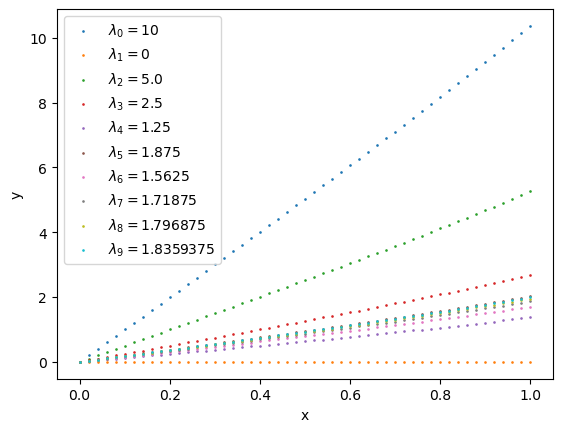

In [3]:
#
# Метод половинного деления для подгонки параметра.
#
def HalfDivision( diff_fn, left, right, threshold, max_iters = 1000):
    assert diff_fn(left, 0)  < 0, 'Must be negative left side'
    assert diff_fn(right, 1) > 0, 'Must be positive right side'
    
    for __i in range(2, max_iters):
        mid = (right + left) / 2
        diff = diff_fn(mid, __i)
        if abs(diff) < threshold:
            return mid
        
        if diff > 0:
            right = mid
        elif diff < 0:
            left  = mid
        else:
            assert 0, 'Unreachable'

    assert 0, 'Cannot minimize'

#
# Расчет невязки параметра (используем в методе половинного деления).
#
def Diff(lamb, it = 0):
    y_left  = 0
    y_right = 2
    h = 0.02
    N = int(1 / h)
    
    n = np.linspace(0, N, N + 1, dtype = np.float64)
    y = Solve(lamb, h, N)
    
    plt.scatter(n * h, y, s = 0.8, label=f'$\lambda_{{{it}}} = {lamb}$')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

    return -(Solve(lamb, h, N)[-1] - y_right)

# Запускаем процедуру подгонки
lamb = HalfDivision(diff_fn = Diff, right = 0, left = 10, threshold = 0.01)
y = Solve(lamb, 0.02, int(1 / 0.02))
print(f'Финальное значение lambda = {lamb}')
print(f'Финальное y(2) = {y[-1]} ~ 2')

# Сохраним для сравнения методов
y_shoot = y

## Метод квазилинеаризации

<img src="XI.9.3.png" width=700/>

Используем линеаризацию по Ньютону:
$$f(y^{m+1}) = f(y^{m}) + \frac{\partial f}{\partial y}(y^{m})\cdot(y^{m+1} - y^{m}),\;\; где \;\;f(y^m) = x\sqrt{y^m}$$
$$\frac{\partial f}{\partial y}(y^{m}) = \frac{x}{2\sqrt{y^m}}$$



Перепишем условие в виде конечно-разностной схемы:
$$\frac{y^{m+1}_{k+1} - 2y^{m+1}_k + y^{m+1}_{k-1}}{h^2} - x_k\sqrt{y^{m+1}_k} = 0, \;\; k = 1, 2, 3, ..., N-1$$

С учетом линеаризации выше, получим систему уравнений:

$$y^{m + 1}_0 = y(0) = 0$$

$$\frac{y^{m+1}_{k+1} - 2y^{m+1}_k + y^{m+1}_{k-1}}{h^2} - x_k\sqrt{y^{m}_k} - \frac{x_k}{2\sqrt{y^m_k}} \cdot(y^{m+1}_k - y^{m}_k) = 0, \;\; k = 1, 2, 3, ..., N-1$$

$$y^{m + 1}_N = y(1) = 2$$

Система выше линейна относительно $y^{m+1}$.

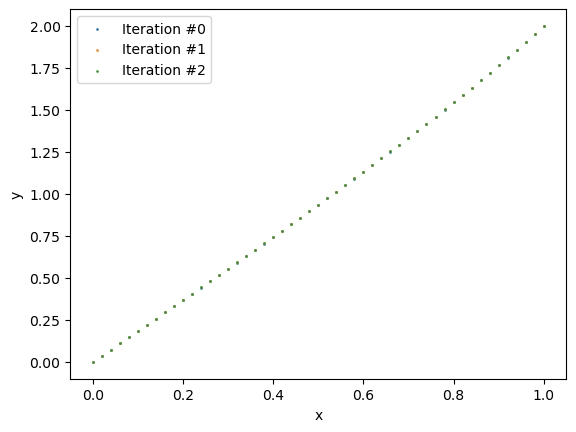

In [4]:
#
# Решить поставленную задачу методом квазилинеаризации.
# 
# Ф-я заполняет матрицу и правый столбец (см. выше). 
# Затем решает СЛУ.
#
def SolveIteration(y, it, h, N):

    # Матрица коэффициентов при y^{m + 1}
    __A = np.zeros((N + 1, N + 1))
    for __i in range(0, N + 1):
        for __j in range(0, N + 1):
            
            if __i == 0: # Левое граничное условие y_{0}
                if __j == 0:
                    __A[__i][__j] = 1
                else:
                    __A[__i][__j] = 0
                continue
                
            if __i == N: # Правое граничное условие y_{N}
                if __j == N:
                    __A[__i][__j] = 1
                else:
                    __A[__i][__j] = 0
                continue
    
            if __i == __j:       # Коэфф. при y_{k}
                __A[__i][__j] = -2 / h**2 - (__i * h) / (2 * np.sqrt(y[__i]))
            elif __i - 1 == __j: # Коэфф. при y_{k-1}
                __A[__i][__j] = 1 / h**2
            elif __i + 1 == __j: # Коэфф. при y_{k+1}
                __A[__i][__j] = 1 / h**2
            else:
                __A[__i][__j] = 0
    
    # Правый столбец:
    __f = np.zeros(N + 1)
    __f[0] = 0 # Левый конец
    __f[N] = 2 # Правый конец
    for __k in range(1, N):
        __f[__k] = 1 / 2 * (__k * h) * np.sqrt(y[__k])
    
    __y = np.linalg.solve(__A, __f)

    __n = np.linspace(0, N, N + 1)
    plt.scatter(__n * h, __y, s = 0.8, label=f'Iteration #{it}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    return __y

h = 0.02
N = int(1 / h)

# Решаем, сколько хотим... Сходится очень быстро!!!
y = np.zeros(N + 1)
y_prev = np.full(N + 1, 1)
for i in range(1000):    
    y = SolveIteration(y_prev, i, h, N)
    if np.max(np.abs(y - y_prev)) < 0.0000001:
        break
    y_prev = y

# Сохраним для сравнения методов
y_newton = y

## Сравнение методов:

0.007362504751050825

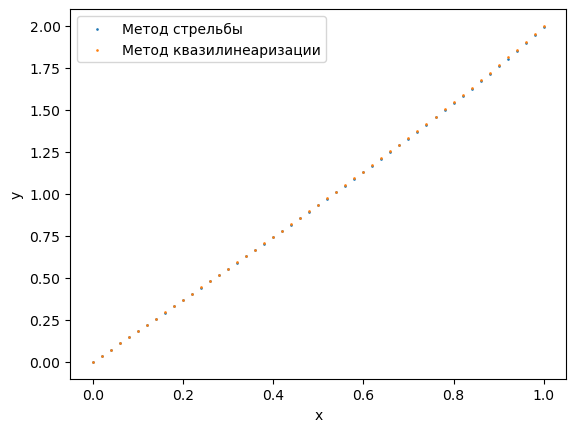

In [5]:
n = np.linspace(0, N, N + 1)

plt.scatter(n * h, y_shoot, s = 0.8, label=f'Метод стрельбы')
plt.scatter(n * h, y_newton, s = 0.8, label=f'Метод квазилинеаризации')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

np.max(np.abs(y_shoot - y_newton))

# XI.9.5

<img src="XI.9.5.png" width=700/>

Разностная схема линейна по $y$, т.е. это линейная краевая задача (халява :) ).

A matrix:
 [[8.         1.         0.         ... 0.         0.         1.        ]
 [1.         8.03141076 1.         ... 0.         0.         0.        ]
 [0.         1.         8.06279052 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 7.90589169 1.         0.        ]
 [0.         0.         0.         ... 1.         7.93720948 1.        ]
 [1.         0.         0.         ... 0.         1.         7.96858924]]


Text(0, 0.5, 'y')

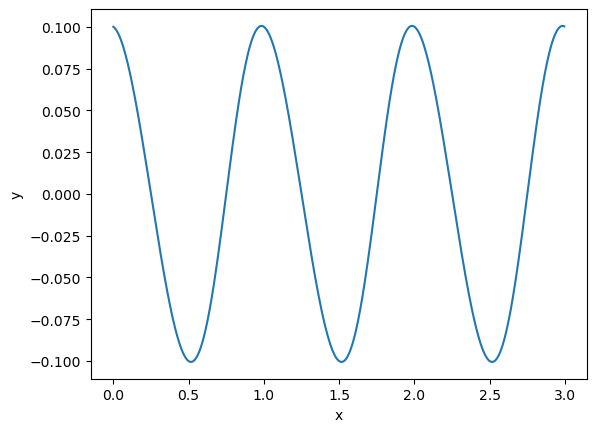

In [6]:
h = 0.005
N = int(1 / h)

n = np.linspace(0, N - 1, N, dtype = np.float64)

P = lambda x: 10 + np.sin(2 * np.pi * x)
f = lambda x: np.cos(2 * np.pi * x)

# Конструируем матрицу по условию
A =   np.diag(np.full(N - 1, 1), -1)                        \
    + np.diag(np.full(N,    -2),  0) + np.diag(P(n * h), 0) \
    + np.diag(np.full(N - 1, 1), +1)

A[-1][0] = 1
A[0][-1] = 1

# Решаем СЛУ
print(f'A matrix:\n {A}')
y = np.linalg.solve(A, f(n * h))

# Повторим график несколько раз периодически (чтобы визуально проверить непрерывность решения)
n_periods = 3
y = np.tile(y, n_periods)
n = np.linspace(0, n_periods * N - 1, n_periods * N, dtype = np.float64)

plt.plot(n * h, y)
plt.xlabel('x')
plt.ylabel('y')